In [28]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as s
import initScripts as script

In [29]:
df = script.loadDataset('H')

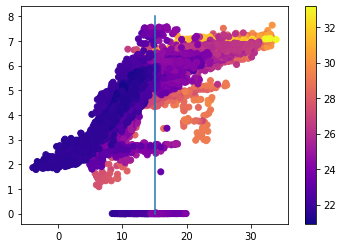

In [30]:
plt.scatter(df['T-outside'],df['KWH'], c=df['T-inside'],cmap='plasma')
plt.plot([15,15],[0,8])
plt.colorbar()
plt.show()

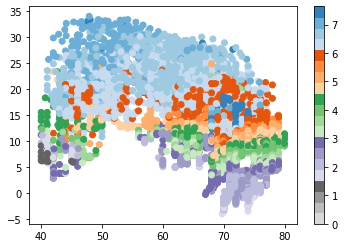

In [31]:
plt.scatter(df['H-outside'],df['T-outside'], c=df['KWH'],cmap='tab20c_r')
plt.colorbar()

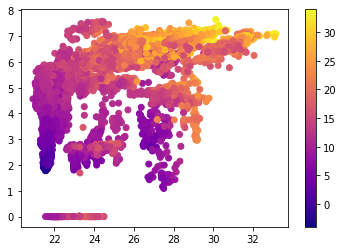

In [32]:
plt.scatter(df['T-inside'],df['KWH'], c=df['T-outside'],cmap='plasma')
plt.colorbar()
plt.show()

C:\Users\William.Brach\Documents\developer\air-conditioning-server-analysis\initScripts.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uci_hourly['hour'] = df_uci_hourly.index.hour


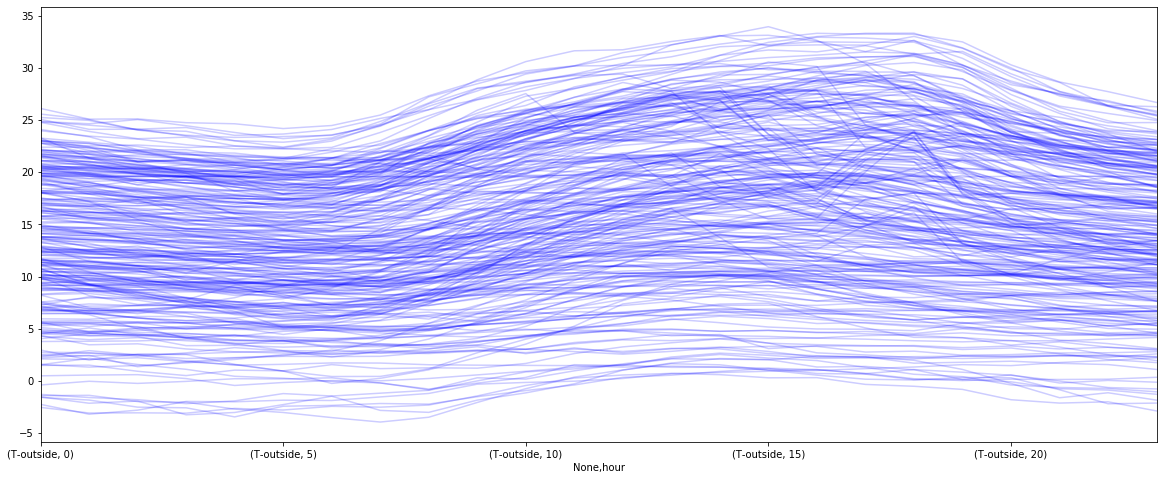

In [33]:
script.hourValueGraph('T-outside',df)

C:\Users\William.Brach\Documents\developer\air-conditioning-server-analysis\initScripts.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uci_hourly['hour'] = df_uci_hourly.index.hour


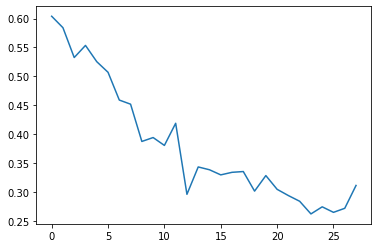

In [34]:
script.silhouetteScoreGraph('T-inside',df)

C:\Users\William.Brach\Documents\developer\air-conditioning-server-analysis\initScripts.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uci_hourly['hour'] = df_uci_hourly.index.hour


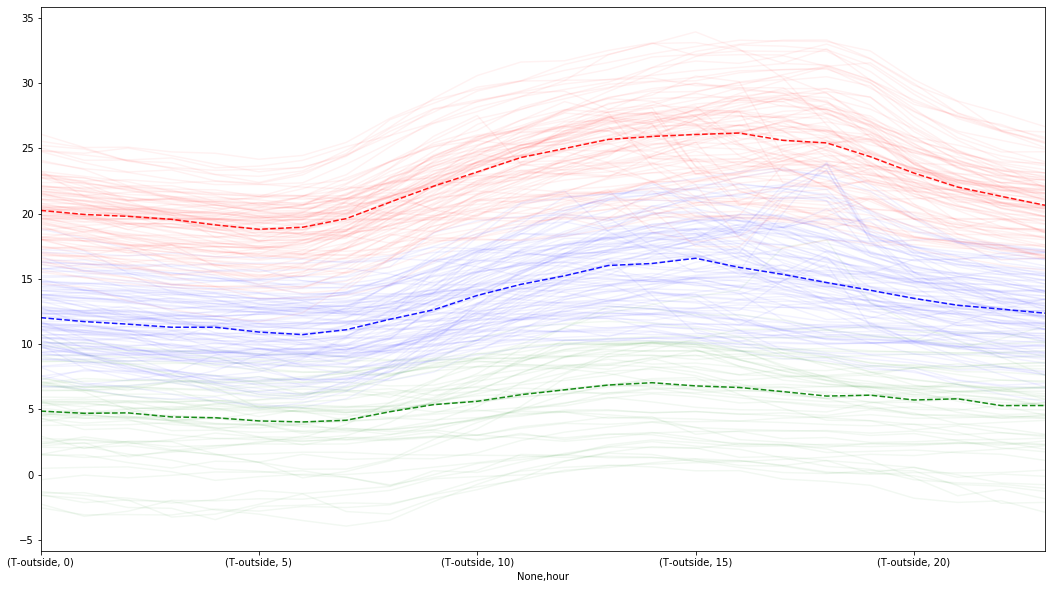

In [35]:
script.kMeansGraphOfClusters('T-outside',df,numOfClusters=3)

C:\Users\William.Brach\Documents\developer\air-conditioning-server-analysis\initScripts.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uci_hourly['hour'] = df_uci_hourly.index.hour


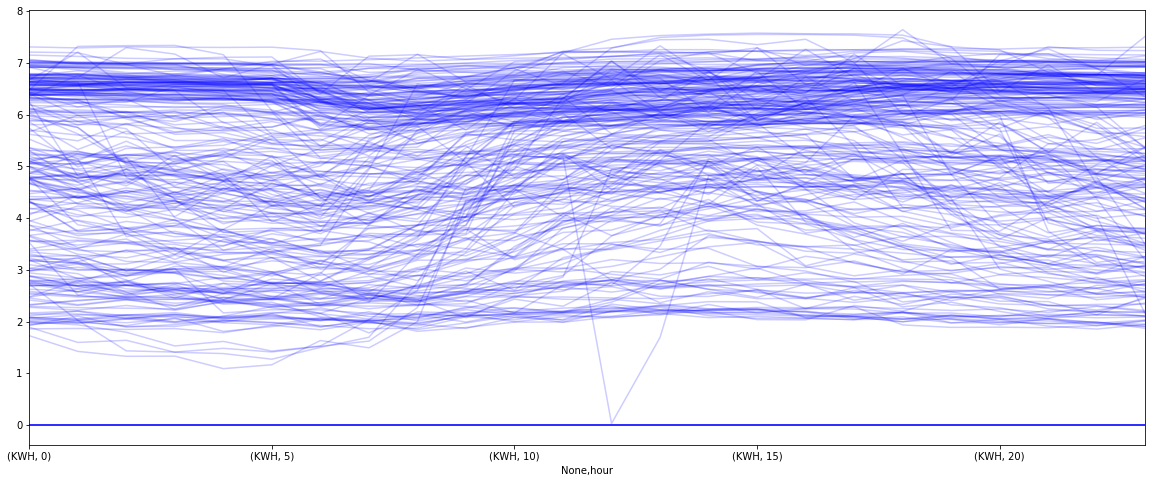

In [36]:
script.hourValueGraph('KWH',df)

C:\Users\William.Brach\Documents\developer\air-conditioning-server-analysis\initScripts.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uci_hourly['hour'] = df_uci_hourly.index.hour


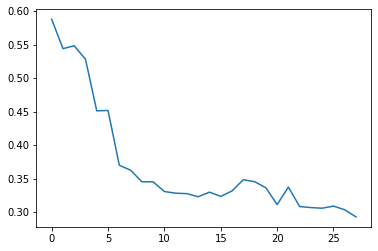

In [37]:
script.silhouetteScoreGraph('KWH',df)

C:\Users\William.Brach\Documents\developer\air-conditioning-server-analysis\initScripts.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uci_hourly['hour'] = df_uci_hourly.index.hour


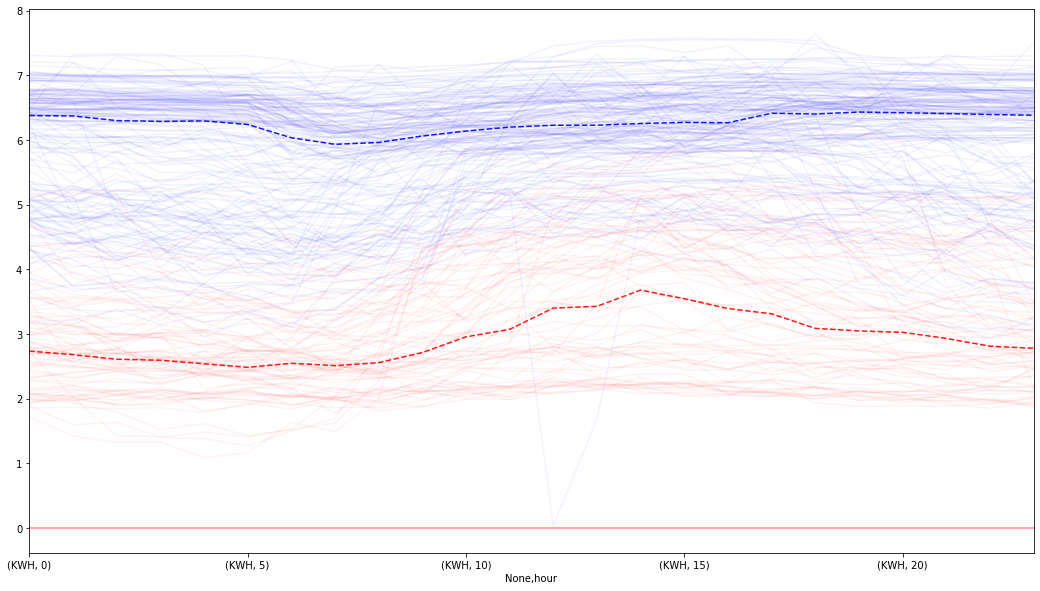

In [38]:
script.kMeansGraphOfClusters('KWH',df,numOfClusters=2)